## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
# ваш код здесь
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# Определяем временные рамки (без учета времени)
start_date = taxi_data['pickup_datetime'].dt.date.min()
end_date = taxi_data['pickup_datetime'].dt.date.max()

print(f"Данные охватывают период с {start_date} по {end_date}")

Данные охватывают период с 2016-01-01 по 2016-06-30


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [4]:
# ваш код здесь
missing_values = taxi_data.isnull().sum().sum()

print(f'Суммарное количество пропущенных значений в данных: {missing_values}')

Суммарное количество пропущенных значений в данных: 0


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [5]:
# ваш код здесь
unique_vendor = taxi_data['vendor_id'].nunique()
print('Количество уникальных таксопарков: ', unique_vendor)

max_pasengeres = taxi_data['passenger_count'].max()
print('Максимальное количество пассажиров: ', max_pasengeres)

mean_duration = int(taxi_data['trip_duration'].mean().round())
median_duration = int(taxi_data['trip_duration'].median().round())
print(f'\nСреднее время поездки: {mean_duration}, медианное время поездки: {median_duration}')

min_duration = taxi_data['trip_duration'].min()
max_duration = taxi_data['trip_duration'].max()
print(f'\nМинимальное время поездки: {min_duration}, максимальное время поездки: {max_duration}')

Количество уникальных таксопарков:  2
Максимальное количество пассажиров:  9

Среднее время поездки: 959, медианное время поездки: 662

Минимальное время поездки: 1, максимальное время поездки: 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [6]:
def add_datetime_features(df):
    # Создаем копию DataFrame чтобы не изменять оригинал
    result_df = df.copy()
    
    # Преобразуем в datetime
    result_df['pickup_datetime'] = pd.to_datetime(result_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    
    # Добавляем новые признаки
    result_df['pickup_date'] = result_df['pickup_datetime'].dt.date
    result_df['pickup_hour'] = result_df['pickup_datetime'].dt.hour
    result_df['pickup_day_of_week'] = result_df['pickup_datetime'].dt.dayofweek
    
    return result_df

taxi_data = add_datetime_features(taxi_data)

# Считаем количество уникальных дней
unique_days = taxi_data['pickup_date'].nunique()

# Считаем общее количество поездок
total_trips = len(taxi_data)

# Вычисляем среднее количество поездок в день
average_trips_per_day = total_trips / unique_days

# Округляем до целого числа
rounded_average = round(average_trips_per_day)

print(f"Среднее количество поездок в день: {rounded_average}")

# Считаем поездки в субботу (день недели 5, где понедельник = 0)
saturday_trips = taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]
print(f"Количество поездок в субботу: {saturday_trips}")

Среднее количество поездок в день: 8015
Количество поездок в субботу: 220868


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [7]:
# ваш код здесь
def add_holiday_features(taxi_data, holiday_data):
    # Создаем копию чтобы не изменять оригинал
    result_df = taxi_data.copy()
    
    # Преобразуем даты к datetime
    holiday_data['date'] = pd.to_datetime(holiday_data['date'])
    result_df['pickup_date'] = pd.to_datetime(result_df['pickup_date'])
    
    # Создаем множество праздничных дней для быстрого поиска
    holiday_dates = set(holiday_data['date'])
    
    # Добавляем бинарный признак праздничного дня
    result_df['pickup_holiday'] = result_df['pickup_date'].isin(holiday_dates).astype(int)
    
    return result_df

# Загружаем данные о праздничных днях
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

# Применяем функцию
taxi_data = add_holiday_features(taxi_data, holiday_data)

# Вычисляем медианную длительность поездки в праздничные дни
holiday_trips = taxi_data[taxi_data['pickup_holiday'] == 1]
holiday_median_duration = holiday_trips['trip_duration'].median()

# Округляем до целого числа
rounded_median = round(holiday_median_duration)

print(f"Медианная длительность поездки в праздничные дни: {rounded_median} секунд")

Медианная длительность поездки в праздничные дни: 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [8]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
# ваш код здесь
def add_osrm_features(taxi_data, osrm_data):
    # Создаем копию чтобы не изменять оригинал
    result_df = taxi_data.copy()
    # Выбираем только нужные столбцы из osrm_data
    osrm_feauters = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    # Объединяем таблицы по столбцу id с типом left join
    result_df = result_df.merge(osrm_feauters, on='id', how='left')
    
    return result_df

taxi_data = add_osrm_features(taxi_data, osrm_data)

# Считаем разницу между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM
result_duration = taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()
print(f'Разница медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM в секундах составила {result_duration:.0f}')

missing_feauters = taxi_data[['total_distance', 'total_travel_time', 'number_of_steps']].isnull().any(axis=1).sum()
print(f'Строк которые содержат пропуски: {missing_feauters.sum()}')

Разница медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM в секундах составила 372
Строк которые содержат пропуски: 1


In [9]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [10]:
# ваш код здесь
def add_geographical_features(taxi_data):
    result_df = taxi_data.copy()
    
    # Вычисляем расстояние по формуле гаверсинуса
    result_df['haversine_distance'] = get_haversine_distance(
        result_df['pickup_latitude'],
        result_df['pickup_longitude'],
        result_df['dropoff_latitude'],
        result_df['dropoff_longitude']
    )
    
    # Вычисляем направление движения
    result_df['direction'] = get_angle_direction(
        result_df['pickup_latitude'],
        result_df['pickup_longitude'],
        result_df['dropoff_latitude'],
        result_df['dropoff_longitude']
    )
    
    return result_df

# Применяем функцию
taxi_data = add_geographical_features(taxi_data)

# Вычисляем медианное расстояние по формуле гаверсинуса
median_haversine = round(taxi_data['haversine_distance'].median(), 2)

print(f'Медианное расстояние поездок равно {median_haversine} км')

Медианное расстояние поездок равно 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [11]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# ваш код здесь
def add_cluster_features(taxi_data, kmeans):
    result_df = taxi_data.copy()
    result_df['geo_cluster'] = kmeans.predict(coords)
    
    return result_df

# Применяем функцию
taxi_data = add_cluster_features(taxi_data, kmeans)

# Считаем количество поездок в каждом кластере
cluster_counts = taxi_data['geo_cluster'].value_counts()

print(f'Количество поездок в наименьшем кластере: {cluster_counts.min()}')

Количество поездок в наименьшем кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [12]:
weather_data = pd.read_csv('data/weather_data.csv')

# ваш код здесь
def add_weather_features(taxi_data, weather_data):
    result_df = taxi_data.copy()
    
    # Оставляем только нужные столбцы в weather_data
    weather_data = weather_data[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    
    # Преобразуем даты к datetime
    weather_data['date'] = pd.to_datetime(weather_data['date'])
    
    # Объединяем таблицы по дате и часу
    result_df = result_df.merge(weather_data,
                                left_on=['pickup_date', 'pickup_hour'],
                                right_on=['date', 'hour'],
                                how='left')
    
    # Удаляем временные столбцы date и hour
    result_df = result_df.drop(['date', 'hour'], axis=1)
    return result_df

# Применяем функцию
taxi_data = add_weather_features(taxi_data, weather_data)

# Считаем поездки в снежную погоду
snow_trips = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
print(f'Количество поездок в снежную погоду: {snow_trips}')

# Вычисляем долю пропусков в погодных столбцах
weather_columns = ['temperature', 'visibility', 'wind speed', 'precip', 'events']


# Считаем количество пропусков в каждом погодном столбце
missing_counts = taxi_data[weather_columns].isnull().sum()

# Считаем общее количество наблюдений
total_observations = len(taxi_data)

# Вычисляем долю пропусков в процентах для каждого столбца
missing_percentages = (missing_counts / total_observations) * 100


# Вычисляем долю пропусков в погодных столбцах
weather_columns = ['temperature', 'visibility', 'wind speed', 'precip', 'events']

# Считаем количество пропусков в каждом погодном столбце
missing_counts = taxi_data[weather_columns].isnull().sum()

# Считаем общее количество наблюдений
total_observations = len(taxi_data)

# Вычисляем долю пропусков в процентах для столбцов с основными погодными условиями
# (исключая events, так как в нем аномально много пропусков)
missing_percentage = (missing_counts['temperature'] / total_observations) * 100
rounded_percentage = round(missing_percentage, 2)

print(f"Доля пропусков в столбцах с погодными условиями: {rounded_percentage}%")

C:\Users\пк\AppData\Local\Temp\ipykernel_15544\1790703118.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data['date'] = pd.to_datetime(weather_data['date'])


Количество поездок в снежную погоду: 13126
Доля пропусков в столбцах с погодными условиями: 0.82%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [13]:
# ваш код здесь
def fill_null_weather_data(taxi_data):
    result_df = taxi_data.copy()
    
    # 1. Заполняем пропуски в погодных столбцах (кроме events) медианой по дате
    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_cols:
        result_df[col] = result_df[col].fillna(
            result_df.groupby('pickup_date')[col].transform('median')
        )
        
    # 2. Заполняем пропуски в events строкой 'None'
    result_df['events'] = result_df['events'].fillna('None')
    
    # 3. Заполняем пропуски в OSRM данных общей медианой
    osrm_cols = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_cols:
        result_df[col] = result_df[col].fillna(result_df[col].median())
    
    return result_df

# Применяем функцию
taxi_data = fill_null_weather_data(taxi_data)

# Вычисляем медиану температуры после заполнения пропусков
median_temperature = round(taxi_data['temperature'].median(), 1)
print(f'Медиана в столбце temperature: {median_temperature}')

Медиана в столбце temperature: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


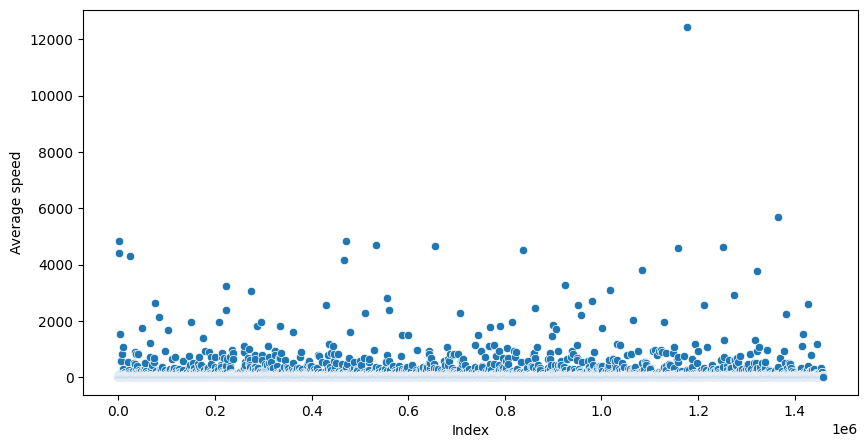

In [14]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [15]:
# ваш код здесь
# 1. Находим выбросы по длительности поездки (более 24 часов)
# 24 часа = 24 * 60 * 60 = 86400 секунд
outliers_duration = taxi_data[taxi_data['trip_duration'] > 86400]

# Количество выбросов
num_outliers_duration = len(outliers_duration)
print(f'Количество выбросов по длительности поездки: {num_outliers_duration}')

# Удаляем выбросы из набора данных
taxi_data = taxi_data[taxi_data['trip_duration'] <= 86400]

# 2. Находим выбросы по средней скорости (более 300 км/ч)
# Вычисляем среднюю скорость в км/ч: расстояние в метрах / время в секундах * 3.6
taxi_data['avg_speed'] = (taxi_data['total_distance'] / taxi_data['trip_duration']) * 3.6

# Находим выбросы по скорости
outliers_speed = taxi_data[taxi_data['avg_speed'] > 300]

# Количество выбросов
num_outliers_speed = len(outliers_speed)
print(f"Количество выбросов по средней скорости (>300 км/ч): {num_outliers_speed}")

# Удаляем выбросы из набора данных
taxi_data = taxi_data[taxi_data['avg_speed'] <= 300]

# Удаляем временный столбец avg_speed
taxi_data = taxi_data.drop('avg_speed', axis=1)

Количество выбросов по длительности поездки: 4
Количество выбросов по средней скорости (>300 км/ч): 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [16]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

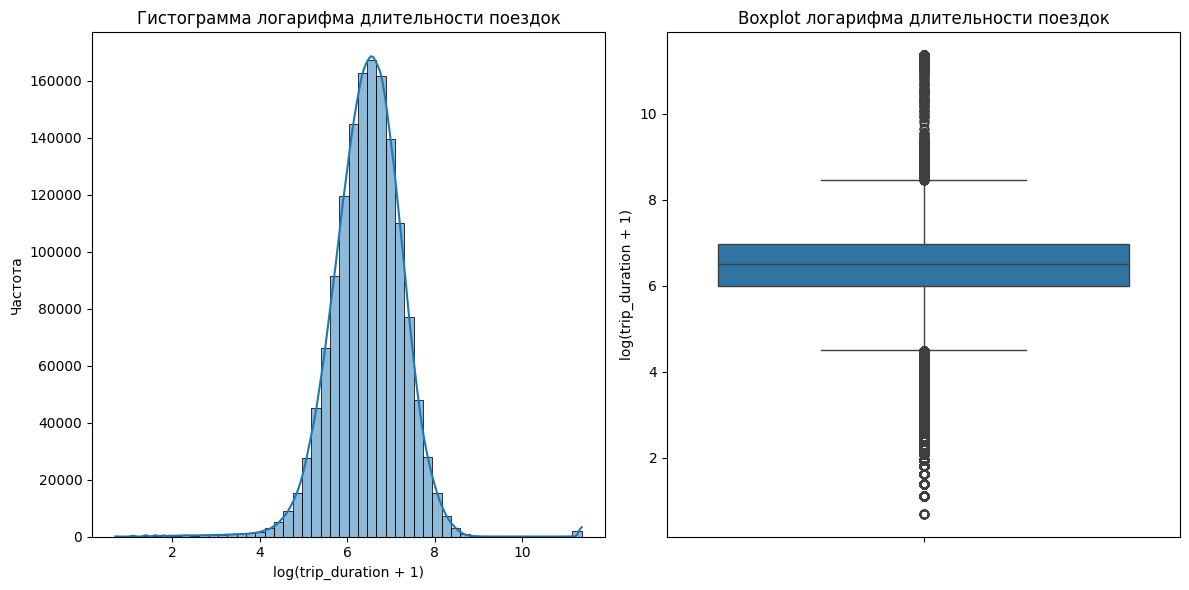

Статистика теста: 138350.1661
P-value: 0.0
Отвергаем нулевую гипотезу: распределение НЕ является нормальным


In [17]:
# ваш код здесь
# Строим гистограмму
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(taxi_data['trip_duration_log'], bins=50, kde=True)
plt.title('Гистограмма логарифма длительности поездок')
plt.xlabel('log(trip_duration + 1)')
plt.ylabel('Частота')

# Строим коробчатую диаграмму
plt.subplot(1, 2, 2)
sns.boxplot(y=taxi_data['trip_duration_log'])
plt.title('Boxplot логарифма длительности поездок')
plt.ylabel('log(trip_duration + 1)')

plt.tight_layout()
plt.show()

# Проверяем нормальность распределения с помощью теста Д'Агстино-Пирсона
statistic, p_value = stats.normaltest(taxi_data['trip_duration_log'])

print(f'Статистика теста: {statistic:.4f}')
print(f'P-value: {p_value}')

# Проверяем гипотезу на уровне значимости 0.05
alpha = 0.05
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение НЕ является нормальным')
else:
    print('Не отвергаем нулевую гипотезу: распределение является нормальным')

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

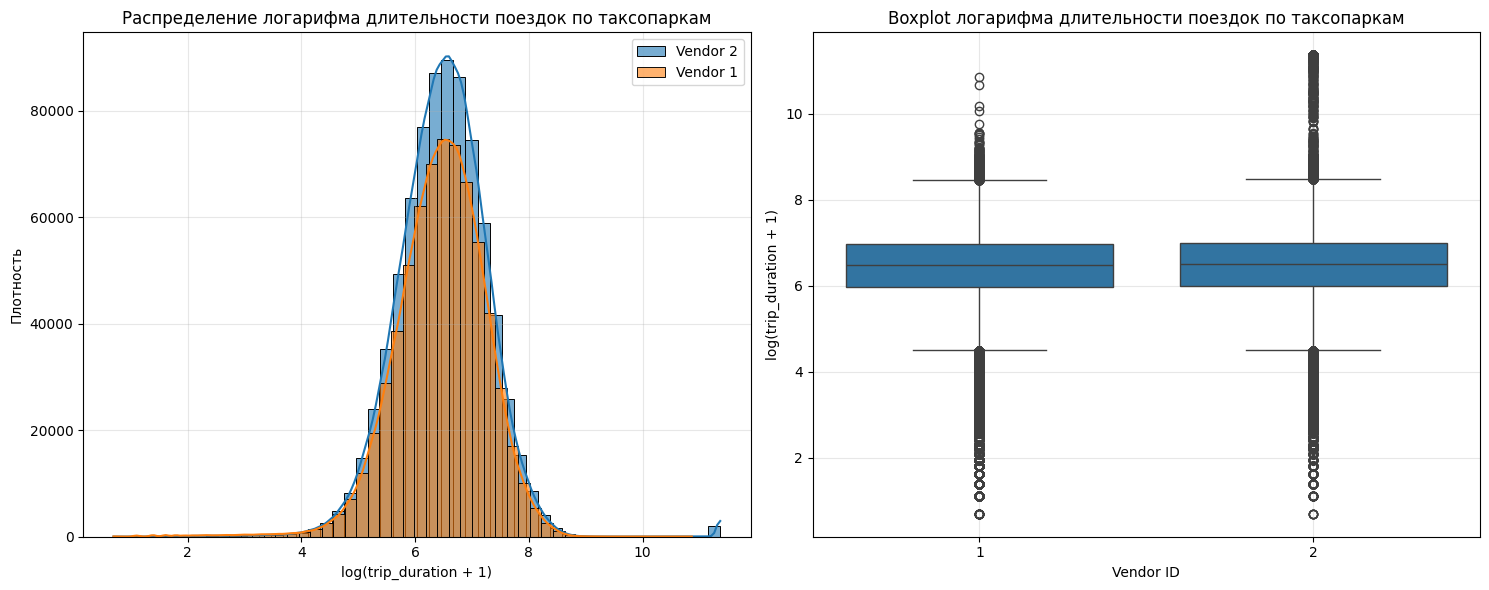

In [18]:
# ваш код здесь
# Строим сравнительные графики для vendor_id
plt.figure(figsize=(15, 6))

# 1. Гистограмма с наложением распределений
plt.subplot(1, 2, 1)
for vendor in taxi_data['vendor_id'].unique():
    vendor_data = taxi_data[taxi_data['vendor_id'] == vendor]['trip_duration_log']
    sns.histplot(vendor_data, bins=50, alpha=0.6, label=f'Vendor {vendor}', kde=True)

plt.title('Распределение логарифма длительности поездок по таксопаркам')
plt.xlabel('log(trip_duration + 1)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Boxplot для сравнения распределений
plt.subplot(1, 2, 2)
sns.boxplot(x='vendor_id', y='trip_duration_log', data=taxi_data)
plt.title('Boxplot логарифма длительности поездок по таксопаркам')
plt.xlabel('Vendor ID')
plt.ylabel('log(trip_duration + 1)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

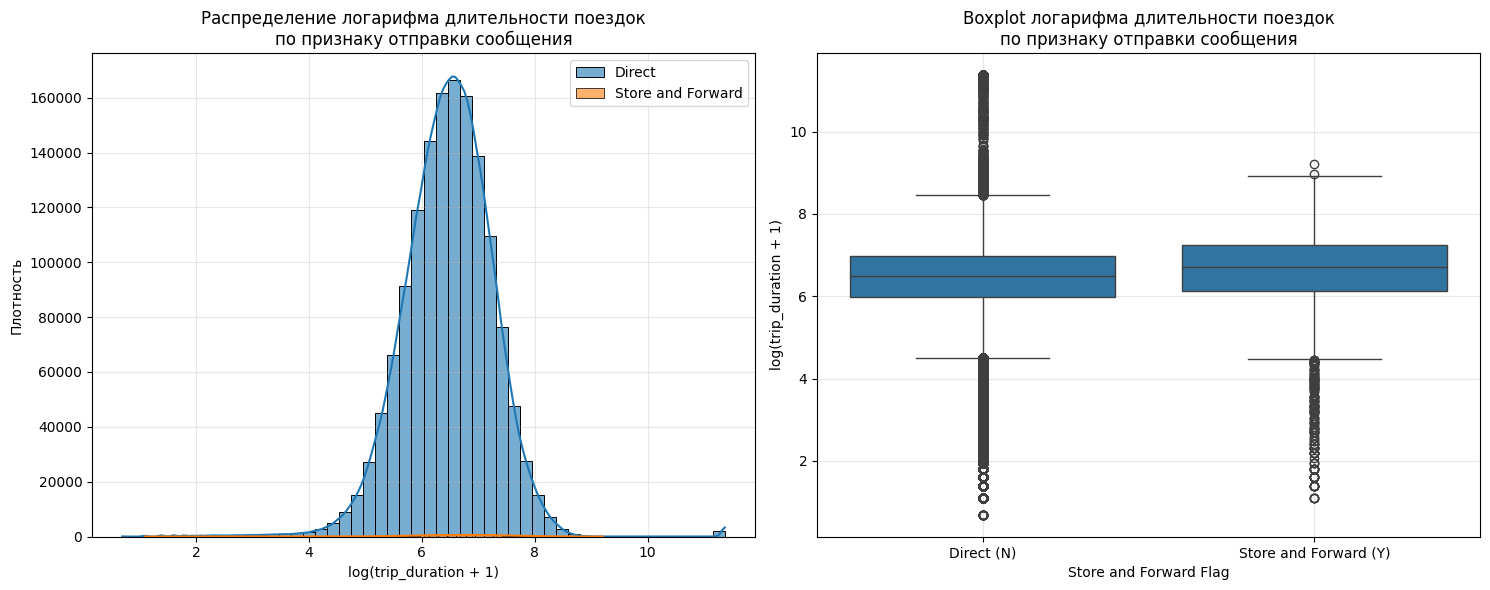

In [19]:
# ваш код здесь
# Строим сравнительные графики для store_and_fwd_flag
plt.figure(figsize=(15, 6))

# 1. Гистограмма с наложением распределений
plt.subplot(1, 2, 1)
for flag in taxi_data['store_and_fwd_flag'].unique():
    flag_data = taxi_data[taxi_data['store_and_fwd_flag'] == flag]['trip_duration_log']
    label = 'Store and Forward' if flag == 'Y' else 'Direct'
    sns.histplot(flag_data, bins=50, alpha=0.6, label=label, kde=True)

plt.title('Распределение логарифма длительности поездок\nпо признаку отправки сообщения')
plt.xlabel('log(trip_duration + 1)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Boxplot для сравнения распределений
plt.subplot(1, 2, 2)
sns.boxplot(x='store_and_fwd_flag', y='trip_duration_log', data=taxi_data)
plt.title('Boxplot логарифма длительности поездок\nпо признаку отправки сообщения')
plt.xlabel('Store and Forward Flag')
plt.ylabel('log(trip_duration + 1)')
plt.xticks([0, 1], ['Direct (N)', 'Store and Forward (Y)'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

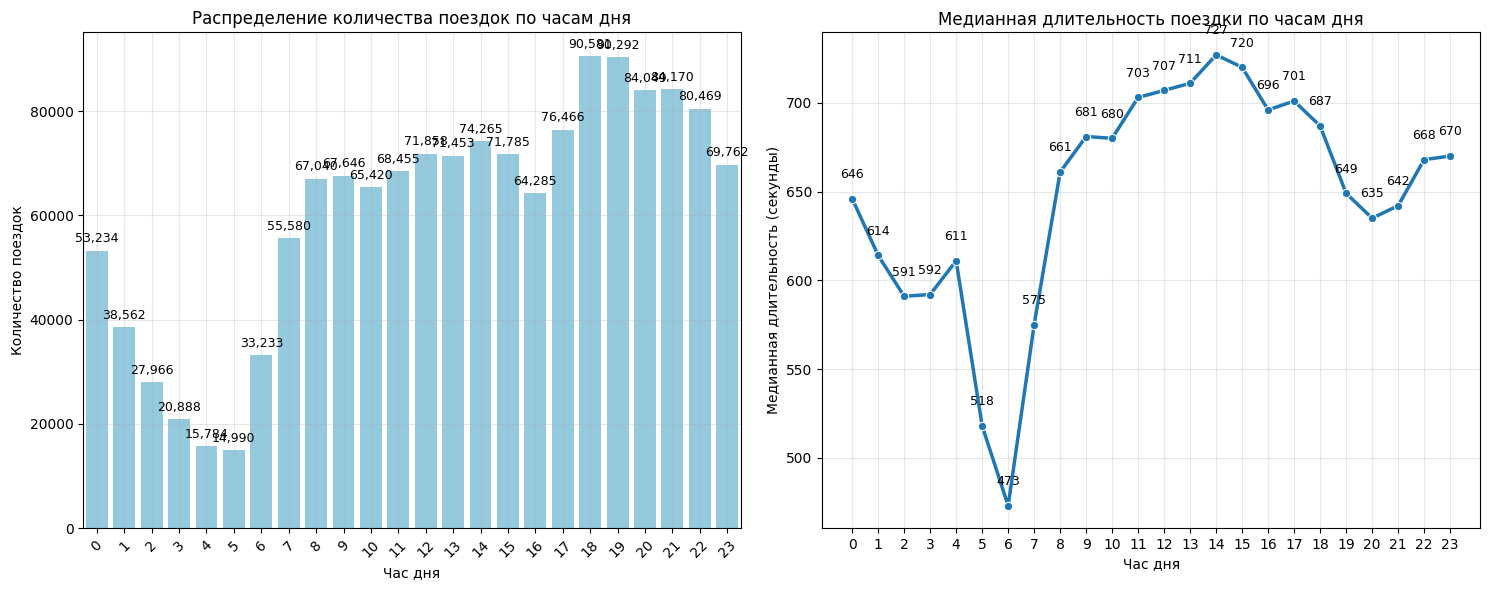

Статистика по часам дня:
Час с максимальным количеством поездок: 18 (90,581 поездок)
Час с минимальным количеством поездок: 5 (14,990 поездок)
Час с максимальной медианной длительностью: 14 (727 сек)
Час с минимальной медианной длительностью: 6 (473 сек)

Корреляция между количеством поездок и медианной длительностью: 0.707


In [20]:
# ваш код здесь
# Строим визуализации зависимости от часа дня
plt.figure(figsize=(15, 6))

# 1. Распределение количества поездок по часам дня
plt.subplot(1, 2, 1)
hourly_counts = taxi_data['pickup_hour'].value_counts().sort_index()
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='skyblue')
plt.title('Распределение количества поездок по часам дня')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, count in enumerate(hourly_counts.values):
    plt.text(i, count + 1000, f'{count:,}', ha='center', va='bottom', fontsize=9)

# 2. Зависимость медианной длительности от часа дня
plt.subplot(1, 2, 2)
hourly_median = taxi_data.groupby('pickup_hour')['trip_duration'].median()
sns.lineplot(x=hourly_median.index, y=hourly_median.values, marker='o', linewidth=2.5)
plt.title('Медианная длительность поездки по часам дня')
plt.xlabel('Час дня')
plt.ylabel('Медианная длительность (секунды)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

# Добавляем значения в точки
for hour, duration in hourly_median.items():
    plt.text(hour, duration + 10, f'{duration:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Дополнительная информация
print("Статистика по часам дня:")
print(f"Час с максимальным количеством поездок: {hourly_counts.idxmax()} ({hourly_counts.max():,} поездок)")
print(f"Час с минимальным количеством поездок: {hourly_counts.idxmin()} ({hourly_counts.min():,} поездок)")
print(f"Час с максимальной медианной длительностью: {hourly_median.idxmax()} ({hourly_median.max():.0f} сек)")
print(f"Час с минимальной медианной длительностью: {hourly_median.idxmin()} ({hourly_median.min():.0f} сек)")

# Корреляция между количеством поездок и длительностью
correlation = hourly_counts.corr(hourly_median)
print(f"\nКорреляция между количеством поездок и медианной длительностью: {correlation:.3f}")

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


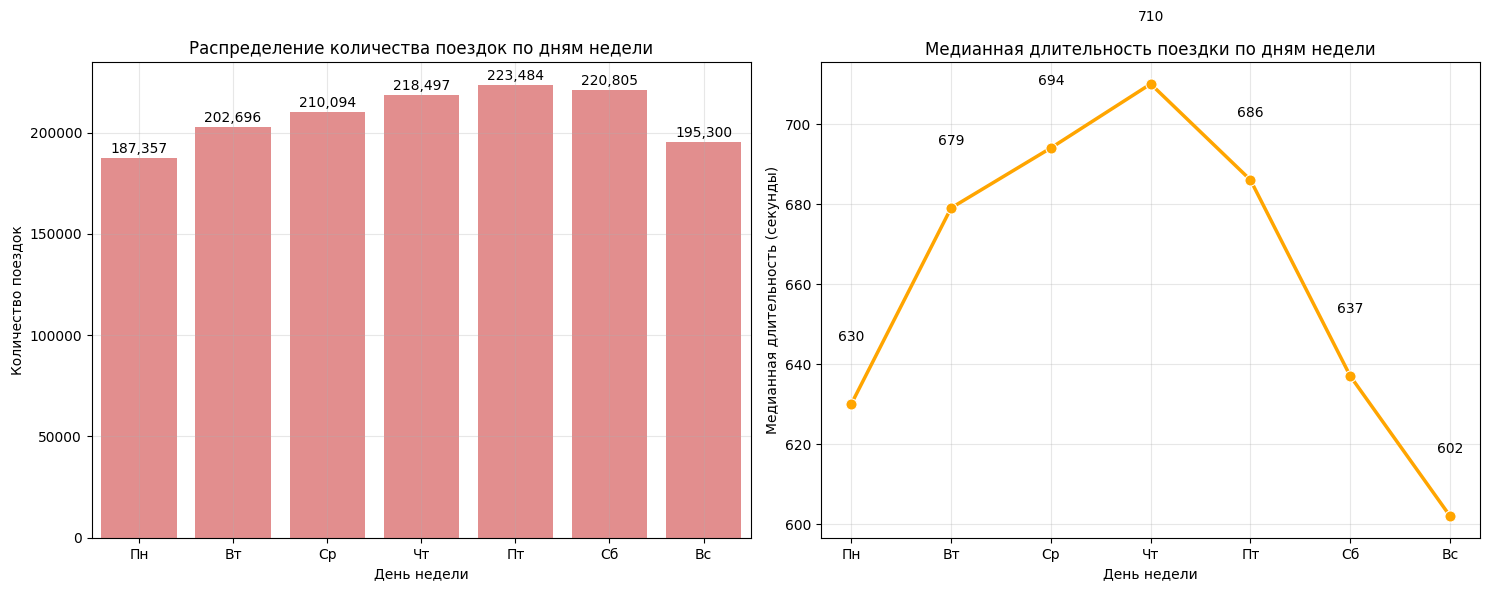

Статистика по дням недели:
День с максимальным количеством поездок: Пт (223,484 поездок)
День с минимальным количеством поездок: Пн (187,357 поездок)
День с максимальной медианной длительностью: Чт (710 сек)
День с минимальной медианной длительностью: Вс (602 сек)


In [21]:
# ваш код здесь
# Строим визуализации зависимости от дня недели
plt.figure(figsize=(15, 6))

# 1. Распределение количества поездок по дням недели
plt.subplot(1, 2, 1)
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
daily_counts = taxi_data['pickup_day_of_week'].value_counts().sort_index()
sns.barplot(x=daily_counts.index, y=daily_counts.values, color='lightcoral')
plt.title('Распределение количества поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(range(7), day_names)
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, count in enumerate(daily_counts.values):
    plt.text(i, count + 1000, f'{count:,}', ha='center', va='bottom', fontsize=10)

# 2. Зависимость медианной длительности от дня недели
plt.subplot(1, 2, 2)
daily_median = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()
sns.lineplot(x=daily_median.index, y=daily_median.values, marker='o', 
             linewidth=2.5, color='orange', markersize=8)
plt.title('Медианная длительность поездки по дням недели')
plt.xlabel('День недели')
plt.ylabel('Медианная длительность (секунды)')
plt.xticks(range(7), day_names)
plt.grid(True, alpha=0.3)

# Добавляем значения в точки
for day, duration in daily_median.items():
    plt.text(day, duration + 15, f'{duration:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительная информация
print("Статистика по дням недели:")
max_day = daily_counts.idxmax()
min_day = daily_counts.idxmin()
print(f"День с максимальным количеством поездок: {day_names[max_day]} ({daily_counts[max_day]:,} поездок)")
print(f"День с минимальным количеством поездок: {day_names[min_day]} ({daily_counts[min_day]:,} поездок)")

max_dur_day = daily_median.idxmax()
min_dur_day = daily_median.idxmin()
print(f"День с максимальной медианной длительностью: {day_names[max_dur_day]} ({daily_median[max_dur_day]:.0f} сек)")
print(f"День с минимальной медианной длительностью: {day_names[min_dur_day]} ({daily_median[min_dur_day]:.0f} сек)")

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

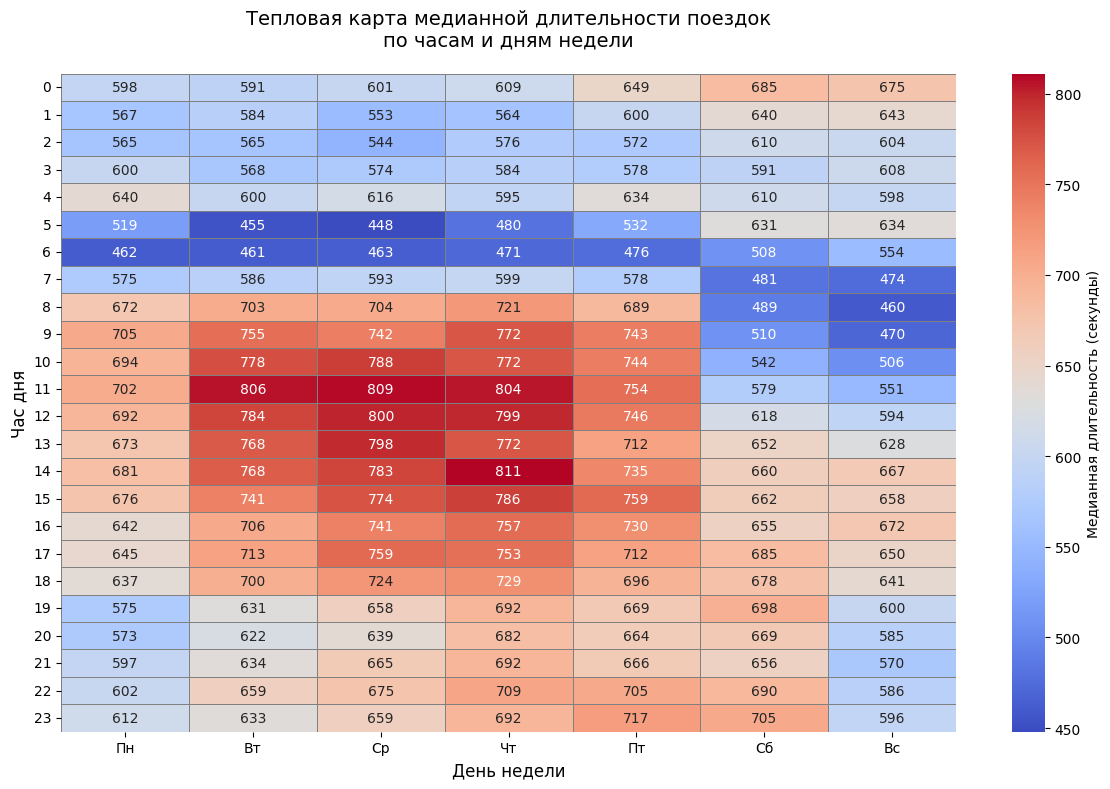

Анализ тепловой карты:
Максимальная медианная длительность: 811 сек
Минимальная медианная длительность: 448 сек


In [22]:
# ваш код здесь
# Создаем сводную таблицу
pivot_table = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

# Переименовываем дни недели для лучшей читаемости
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
pivot_table.columns = day_names

# Визуализируем тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, 
            cmap='coolwarm', 
            annot=True, 
            fmt='.0f', 
            cbar_kws={'label': 'Медианная длительность (секунды)'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Тепловая карта медианной длительности поездок\nпо часам и дням недели', fontsize=14, pad=20)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Час дня', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Дополнительный анализ
print("Анализ тепловой карты:")
print(f"Максимальная медианная длительность: {pivot_table.max().max():.0f} сек")
print(f"Минимальная медианная длительность: {pivot_table.min().min():.0f} сек")

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


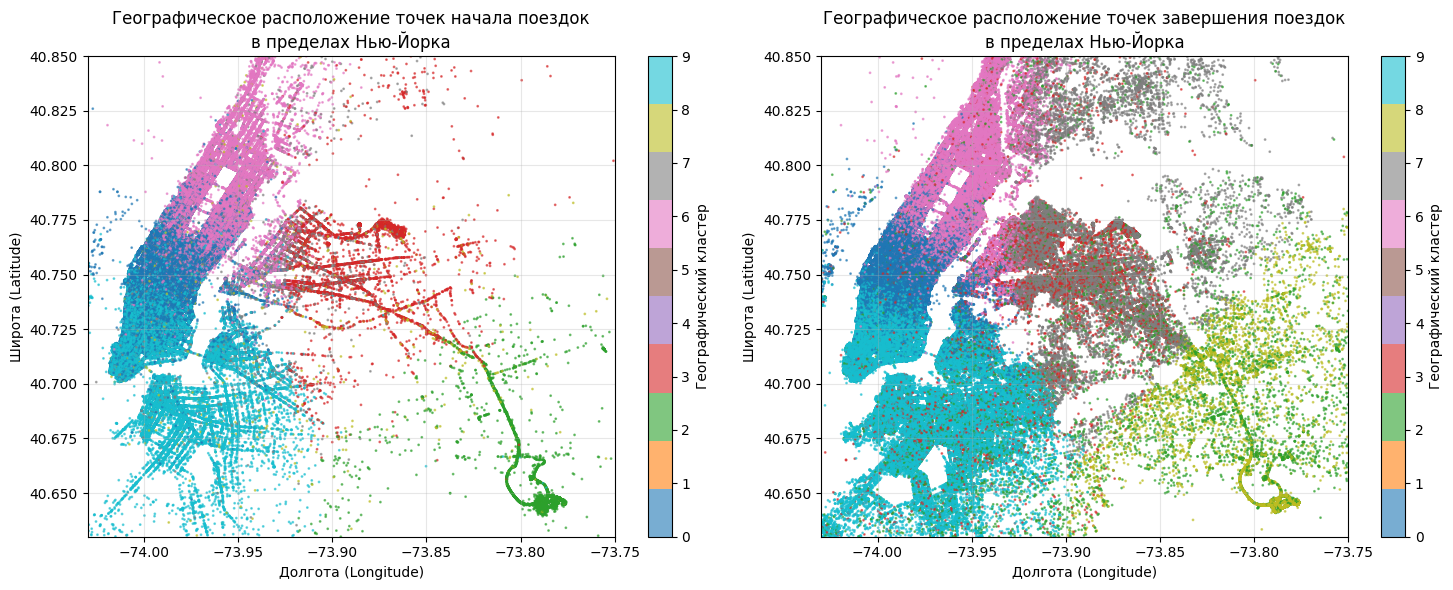

In [23]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# ваш код здесь
# Фильтруем данные только для точек в пределах Нью-Йорка
nyc_pickups = taxi_data[
    (taxi_data['pickup_longitude'].between(city_long_border[0], city_long_border[1])) &
    (taxi_data['pickup_latitude'].between(city_lat_border[0], city_lat_border[1]))
]

nyc_dropoffs = taxi_data[
    (taxi_data['dropoff_longitude'].between(city_long_border[0], city_long_border[1])) &
    (taxi_data['dropoff_latitude'].between(city_lat_border[0], city_lat_border[1]))
]

# Строим диаграммы рассеяния
plt.figure(figsize=(15, 6))

# 1. Точки начала поездок
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(nyc_pickups['pickup_longitude'], 
                      nyc_pickups['pickup_latitude'],
                      c=nyc_pickups['geo_cluster'], 
                      cmap='tab10', 
                      s=1,  # уменьшаем размер точек
                      alpha=0.6)
plt.colorbar(scatter1, label='Географический кластер')
plt.title('Географическое расположение точек начала поездок\nв пределах Нью-Йорка')
plt.xlabel('Долгота (Longitude)')
plt.ylabel('Широта (Latitude)')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.grid(True, alpha=0.3)

# 2. Точки завершения поездок
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(nyc_dropoffs['dropoff_longitude'], 
                      nyc_dropoffs['dropoff_latitude'],
                      c=nyc_dropoffs['geo_cluster'], 
                      cmap='tab10', 
                      s=1,  # уменьшаем размер точек
                      alpha=0.6)
plt.colorbar(scatter2, label='Географический кластер')
plt.title('Географическое расположение точек завершения поездок\nв пределах Нью-Йорка')
plt.xlabel('Долгота (Longitude)')
plt.ylabel('Широта (Latitude)')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ: сколько кластеров не попало в границы Нью-Йорка
all_clusters = set(taxi_data['geo_cluster'].unique())
nyc_pickup_clusters = set(nyc_pickups['geo_cluster'].unique())
nyc_dropoff_clusters = set(nyc_dropoffs['geo_cluster'].unique())

# Кластеры, которые есть в данных, но не попали на карту Нью-Йорка
missing_pickup_clusters = all_clusters - nyc_pickup_clusters
missing_dropoff_clusters = all_clusters - nyc_dropoff_clusters

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [24]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [25]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [26]:
# ваш код здесь
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [27]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [28]:
# ваш код здесь
# 1. Закодируем vendor_id: 0 если vendor_id == 1, 1 в противном случае
train_data['vendor_id'] = (train_data['vendor_id'] != 1).astype(int)

# 2. Закодируем store_and_fwd_flag: 0 если 'N', 1 в противном случае
train_data['store_and_fwd_flag'] = (train_data['store_and_fwd_flag'] != 'N').astype(int)

# Вычисляем средние значения
vendor_mean = train_data['vendor_id'].mean()
store_mean = train_data['store_and_fwd_flag'].mean()

print(f"Среднее по закодированному vendor_id: {vendor_mean:.2f}")
print(f"\nСреднее по закодированному store_and_fwd_flag: {store_mean:.3f}")

Среднее по закодированному vendor_id: 0.53

Среднее по закодированному store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [29]:
# ваш код здесь
# Выбираем категориальные признаки для кодирования
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# Создаем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Применяем кодирование
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change])
data_onehot = data_onehot.toarray()

# Получаем имена закодированных столбцов
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)

# Преобразуем в DataFrame
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

# Подсчитываем количество бинарных столбцов после one-hot кодирования
binary_columns_count = data_onehot.shape[1]

print(f'Количество бинарных столбцов после кодирования: {binary_columns_count}')

data_onehot.head()

Количество бинарных столбцов после кодирования: 18


,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [30]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [31]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [32]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [33]:
# ваш код здесь
# Отбираем 25 лучших признаков
selector = SelectKBest(score_func=f_regression, k=25)
X_train_selected = selector.fit_transform(X_train, y_train_log)
X_valid_selected = selector.transform(X_valid)

# Получаем имена отобранных признаков
selected_features = X_train.columns[selector.get_support()].tolist()

print(f'Отобрано признаков: {len(selected_features)}')
print('\nОтобранные признаки:')
for i, feature in enumerate(selected_features, 1):
    print(f'{i}. {feature}')
    
# Сохраняем отобранные признаки для дальнейшего использования
X_train = pd.DataFrame(X_train_selected, columns=selected_features)
X_valid = pd.DataFrame(X_valid_selected, columns=selected_features)

Отобрано признаков: 25

Отобранные признаки:
1. vendor_id
2. passenger_count
3. pickup_longitude
4. pickup_latitude
5. dropoff_longitude
6. dropoff_latitude
7. store_and_fwd_flag
8. pickup_hour
9. pickup_holiday
10. total_distance
11. total_travel_time
12. number_of_steps
13. haversine_distance
14. temperature
15. pickup_day_of_week_1
16. pickup_day_of_week_2
17. pickup_day_of_week_3
18. pickup_day_of_week_4
19. pickup_day_of_week_5
20. pickup_day_of_week_6
21. geo_cluster_2
22. geo_cluster_3
23. geo_cluster_6
24. geo_cluster_7
25. geo_cluster_8


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [34]:
# ваш код здесь
# Создаем и обучаем нормализатор на обучающей выборке
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Преобразуем обратно в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

# Рассчитываем среднее арифметическое для первого предиктора в валидационной выборке
first_pred_mean = X_valid_scaled.iloc[:, 0].mean()

print(f'Среднее арифметическое для первого предиктора в валидационной выборке: {first_pred_mean:.2f}')

Среднее арифметическое для первого предиктора в валидационной выборке: 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [35]:
# ваш код здесь
# Создаем и обучаем модель линейной регрессии
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled, y_train_log)

# Делаем предсказания на тренировочной и валидационной выборках
y_train_pred_log = lr_model.predict(X_train_scaled)
y_valid_pred_log = lr_model.predict(X_valid_scaled)

# Вычисляем RMSLE на тренировочной выборке
rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log))

# Вычисляем RMSLE на валидационной выборке  
rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log))

print(f"RMSLE на тренировочной выборке: {rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {rmsle_valid:.2f}")

RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [36]:
# ваш код здесь
# Создаем полиномиальные признаки второй степени
poly = PolynomialFeatures(degree=2, include_bias=False)

# Применяем преобразование к обучающей и валидационной выборкам
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# Создаем и обучаем модель полиномиальной регрессии
poly_model = linear_model.LinearRegression()
poly_model.fit(X_train_poly, y_train_log)

# Делаем предсказания
y_train_pred_log_poly = poly_model.predict(X_train_poly)
y_valid_pred_log_poly = poly_model.predict(X_valid_poly)

# Вычисляем RMSLE
rmsle_train_poly = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log_poly))
rmsle_valid_poly = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log_poly))

print(f"\nRMSLE на тренировочной выборке (полиномиальная регрессия): {rmsle_train_poly:.2f}")
print(f"RMSLE на валидационной выборке (полиномиальная регрессия): {rmsle_valid_poly:.2f}")


RMSLE на тренировочной выборке (полиномиальная регрессия): 0.47
RMSLE на валидационной выборке (полиномиальная регрессия): 0.69


### У модели наблюдаются признаки переобучения

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [37]:
# ваш код здесь
# Создаем и обучаем модель Ridge регрессии (L2-регуляризация)
ridge_model = linear_model.Ridge(alpha=1.0)  # alpha = 1 - коэффициент регуляризации
ridge_model.fit(X_train_poly, y_train_log)

# Делаем предсказания
y_train_pred_log_ridge = ridge_model.predict(X_train_poly)
y_valid_pred_log_ridge = ridge_model.predict(X_valid_poly)

# Вычисляем RMSLE
rmsle_train_ridge = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log_ridge))
rmsle_valid_ridge = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log_ridge))

print(f"RMSLE на тренировочной выборке (Ridge регрессия): {rmsle_train_ridge:.2f}")
print(f"RMSLE на валидационной выборке (Ridge регрессия): {rmsle_valid_ridge:.2f}")

RMSLE на тренировочной выборке (Ridge регрессия): 0.48
RMSLE на валидационной выборке (Ridge регрессия): 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [38]:
# ваш код здесь
# Создаем и обучаем модель дерева решений
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train_log)

# Делаем предсказания
y_train_pred_log_tree = tree_model.predict(X_train_scaled)
y_valid_pred_log_tree = tree_model.predict(X_valid_scaled)

# Вычисляем RMSLE
rmsle_train_tree = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log_tree))
rmsle_valid_tree = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log_tree))

print(f"RMSLE на тренировочной выборке (Decision Tree): {rmsle_train_tree:.2f}")
print(f"RMSLE на валидационной выборке (Decision Tree): {rmsle_valid_tree:.2f}")

RMSLE на тренировочной выборке (Decision Tree): 0.00
RMSLE на валидационной выборке (Decision Tree): 0.57


### У модели наблюдаются признаки переобучения

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


Глубина 7: Train RMSLE = 0.44, Valid RMSLE = 0.45
Глубина 8: Train RMSLE = 0.44, Valid RMSLE = 0.44
Глубина 9: Train RMSLE = 0.43, Valid RMSLE = 0.44
Глубина 10: Train RMSLE = 0.42, Valid RMSLE = 0.43
Глубина 11: Train RMSLE = 0.41, Valid RMSLE = 0.43
Глубина 12: Train RMSLE = 0.41, Valid RMSLE = 0.43
Глубина 13: Train RMSLE = 0.40, Valid RMSLE = 0.43
Глубина 14: Train RMSLE = 0.38, Valid RMSLE = 0.44
Глубина 15: Train RMSLE = 0.37, Valid RMSLE = 0.45
Глубина 16: Train RMSLE = 0.36, Valid RMSLE = 0.45
Глубина 17: Train RMSLE = 0.34, Valid RMSLE = 0.46
Глубина 18: Train RMSLE = 0.32, Valid RMSLE = 0.47
Глубина 19: Train RMSLE = 0.30, Valid RMSLE = 0.48


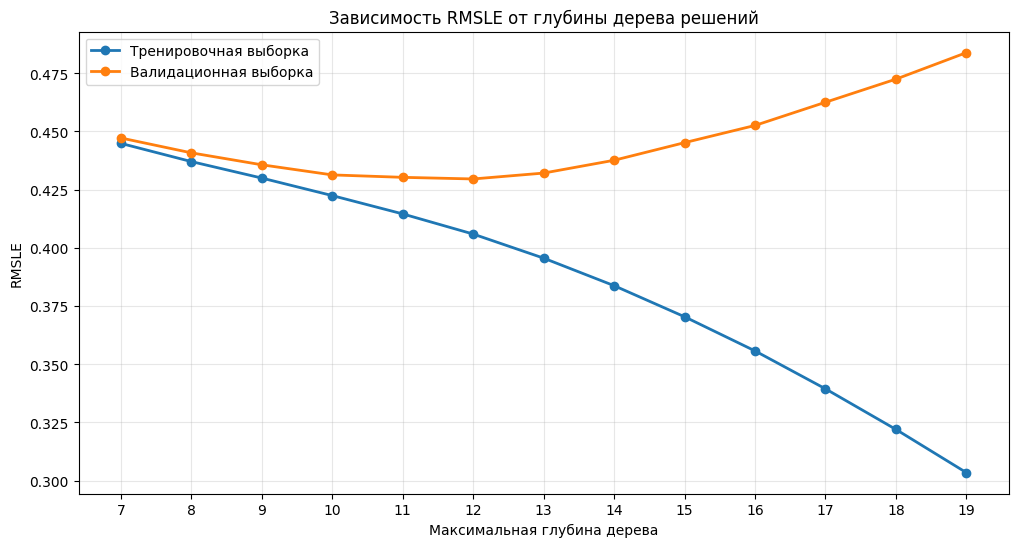


Оптимальная глубина дерева: 12
Минимальный RMSLE на валидационной выборке: 0.43


In [39]:
# ваш код здесь
max_depths = range(7, 20)
train_scores = []
valid_scores = []

# Перебираем глубины дерева
for depth in max_depths:
    # Создаем и обучаем модель
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_model.fit(X_train_scaled, y_train_log)
    
    # Предсказания и метрики
    y_train_pred = tree_model.predict(X_train_scaled)
    y_valid_pred = tree_model.predict(X_valid_scaled)
    
    rmsle_train = np.sqrt(mean_squared_error(y_train_log, y_train_pred))
    rmsle_valid = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred))
    
    train_scores.append(rmsle_train)
    valid_scores.append(rmsle_valid)
    
    print(f"Глубина {depth}: Train RMSLE = {rmsle_train:.2f}, Valid RMSLE = {rmsle_valid:.2f}")

# Строим графики
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_scores, 'o-', label='Тренировочная выборка', linewidth=2)
plt.plot(max_depths, valid_scores, 'o-', label='Валидационная выборка', linewidth=2)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('RMSLE')
plt.title('Зависимость RMSLE от глубины дерева решений')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(max_depths)
plt.show()

# Находим оптимальную глубину
optimal_depth = max_depths[np.argmin(valid_scores)]
min_valid_score = min(valid_scores)

print(f"\nОптимальная глубина дерева: {optimal_depth}")
print(f"Минимальный RMSLE на валидационной выборке: {min_valid_score:.2f}")

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [40]:
# ваш код здесь
# Создаем и обучаем модель случайного леса
rf_model = RandomForestRegressor(
    n_estimators = 200,
    max_depth = 12,
    criterion = 'squared_error',
    min_samples_split = 20,
    random_state = 42,
    verbose=1,
    n_jobs=-1
)

print('Начинаем обучение случайного леса...')
rf_model.fit(X_train_scaled, y_train_log)
print('Обучение завершено!')

# Делаем предсказания
y_train_pred_log_rf = rf_model.predict(X_train_scaled)
y_valid_pred_log_rf = rf_model.predict(X_valid_scaled)

# Вычисляем RMSLE
rmsle_train_rf = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log_rf))
rmsle_valid_rf = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log_rf))

print(f"\nRMSLE на тренировочной выборке (Random Forest): {rmsle_train_rf:.2f}")
print(f"RMSLE на валидационной выборке (Random Forest): {rmsle_valid_rf:.2f}")

Начинаем обучение случайного леса...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.7min finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.


Обучение завершено!


[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    1.4s
[Parallel(n_jobs=28)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:    0.6s
[Parallel(n_jobs=28)]: Done 200 out of 200 | elapsed:    0.8s finished



RMSLE на тренировочной выборке (Random Forest): 0.40
RMSLE на валидационной выборке (Random Forest): 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

In [41]:
# ваш код здесь
# Создаем и обучаем модель градиентного бустинга
gb_model = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=1  # Показываем прогресс обучения
)

print("Начинаем обучение градиентного бустинга...")
gb_model.fit(X_train_scaled, y_train_log)
print("Обучение завершено!")

# Делаем предсказания
y_train_pred_log_gb = gb_model.predict(X_train_scaled)
y_valid_pred_log_gb = gb_model.predict(X_valid_scaled)

# Вычисляем RMSLE
rmsle_train_gb = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log_gb))
rmsle_valid_gb = np.sqrt(mean_squared_error(y_valid_log, y_valid_pred_log_gb))

print(f"\nRMSLE на тренировочной выборке (Gradient Boosting): {rmsle_train_gb:.2f}")
print(f"RMSLE на валидационной выборке (Gradient Boosting): {rmsle_valid_gb:.2f}")

Начинаем обучение градиентного бустинга...
      Iter       Train Loss   Remaining Time 
         1           0.3110           13.01m
         2           0.2247           12.81m
         3           0.1987           12.77m
         4           0.1876           12.57m
         5           0.1822           12.43m
         6           0.1787           12.27m
         7           0.1753           12.17m
         8           0.1725           12.01m
         9           0.1698           11.84m
        10           0.1685           11.72m
        20           0.1589           10.37m
        30           0.1549            8.99m
        40           0.1507            7.66m
        50           0.1480            6.38m
        60           0.1452            5.09m
        70           0.1438            3.82m
        80           0.1413            2.55m
        90           0.1397            1.27m
       100           0.1382            0.00s
Обучение завершено!

RMSLE на тренировочной выборке (Gra

### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Лучшая модель - Градиентный бустинг над деревьями решений

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


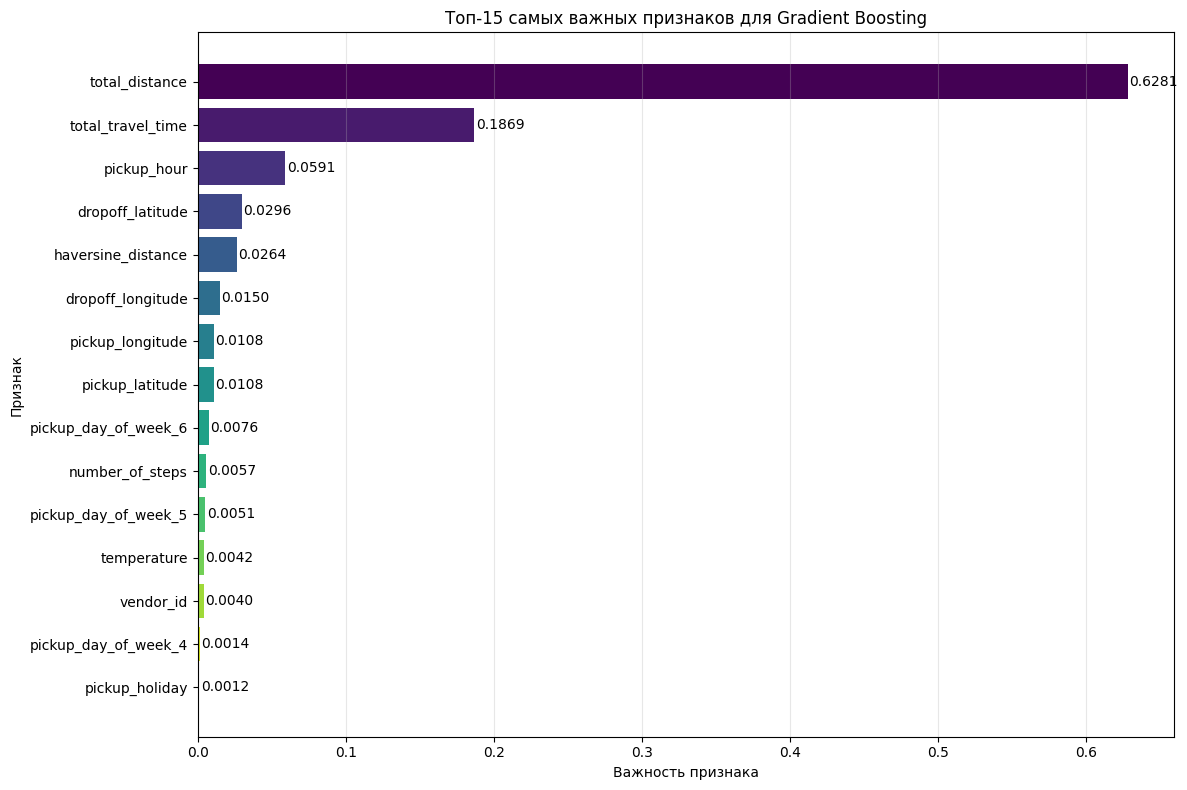

Топ-3 самых важных признаков:
1. total_distance - важность: 0.628119
2. total_travel_time - важность: 0.186875
3. pickup_hour - важность: 0.059080


In [42]:
# ваш код здесь
# Важность признаков
feature_importance_gb = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Строим столбчатую диаграмму важности признаков
plt.figure(figsize=(12, 8))
top_features = feature_importance_gb.head(15)  # Топ-15 признаков

colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = plt.barh(top_features['feature'], top_features['importance'], color=colors)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Топ-15 самых важных признаков для Gradient Boosting')
plt.gca().invert_yaxis()  # Самый важный признак сверху

# Добавляем значения на столбцы
for i, (feature, importance) in enumerate(zip(top_features['feature'], top_features['importance'])):
    plt.text(importance + 0.001, i, f'{importance:.4f}', va='center', fontsize=10)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Выводим топ-3 самых важных признаков
top_3_features = feature_importance_gb.head(3)
print("Топ-3 самых важных признаков:")
for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"{i}. {row['feature']} - важность: {row['importance']:.6f}")

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [43]:
# ваш код здесь
# Используем лучшую модель - Gradient Boosting
# Переводим предсказания из логарифмического масштаба в изначальный
y_valid_pred = np.exp(y_valid_pred_log_gb) - 1
y_valid_true = np.exp(y_valid_log) - 1

# Вычисляем медианную абсолютную ошибку в секундах
meae_seconds = median_absolute_error(y_valid_true, y_valid_pred)

# Переводим секунды в минуты
meae_minutes = meae_seconds / 60

print(f"В минутах: {meae_minutes:.1f} мин")

В минутах: 1.8 мин


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [44]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [45]:
def add_cluster_features(df, kmeans_model):
    # Создаем копию чтобы не изменять оригинал
    result_df = df.copy()
    
    # Создаем координаты ИЗ ПЕРЕДАННОГО DataFrame
    coords = np.hstack((result_df[['pickup_latitude', 'pickup_longitude']],
                        result_df[['dropoff_latitude', 'dropoff_longitude']]))
    
    # Применяем обученную модель для предсказания кластеров
    result_df['geo_cluster'] = kmeans_model.predict(coords)
    
    return result_df

In [46]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[selected_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

C:\Users\пк\AppData\Local\Temp\ipykernel_15544\1790703118.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data['date'] = pd.to_datetime(weather_data['date'])


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [47]:
# ваш код здесь
# Создаем предсказание для тестовой выборки используя нашу лучшую модель (Gradient Boosting)
print("Создаем прогноз для тестовой выборки...")
y_test_pred_log = gb_model.predict(X_test_scaled)

# Преобразование из логарифмического масштаба обратно в истинные секунды
y_test_predict = np.exp(y_test_pred_log) - 1

# Создание submission файла
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

Создаем прогноз для тестовой выборки...


c:\Users\пк\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [48]:
#pip install xgboost

После чего модуль можно импортировать:

In [49]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [51]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=selected_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=selected_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=selected_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [52]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73989	valid-rmse:0.74189
[10]	train-rmse:0.49092	valid-rmse:0.49353
[20]	train-rmse:0.44083	valid-rmse:0.44372
[30]	train-rmse:0.42661	valid-rmse:0.42966
[40]	train-rmse:0.41877	valid-rmse:0.42202
[50]	train-rmse:0.41365	valid-rmse:0.41712
[60]	train-rmse:0.40969	valid-rmse:0.41345
[70]	train-rmse:0.40711	valid-rmse:0.41117
[80]	train-rmse:0.40488	valid-rmse:0.40923
[90]	train-rmse:0.40256	valid-rmse:0.40717
[100]	train-rmse:0.40125	valid-rmse:0.40612
[110]	train-rmse:0.39953	valid-rmse:0.40467
[120]	train-rmse:0.39841	valid-rmse:0.40383
[130]	train-rmse:0.39704	valid-rmse:0.40281
[140]	train-rmse:0.39569	valid-rmse:0.40171
[150]	train-rmse:0.39471	valid-rmse:0.40099
[160]	train-rmse:0.39388	valid-rmse:0.40049
[170]	train-rmse:0.39304	valid-rmse:0.39985
[180]	train-rmse:0.39213	valid-rmse:0.39918
[190]	train-rmse:0.39132	valid-rmse:0.39860
[200]	train-rmse:0.39049	valid-rmse:0.39802
[210]	train-rmse:0.38974	valid-rmse:0.39763
[220]	train-rmse:0.38911	valid-rmse:0.39727

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [53]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39462


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

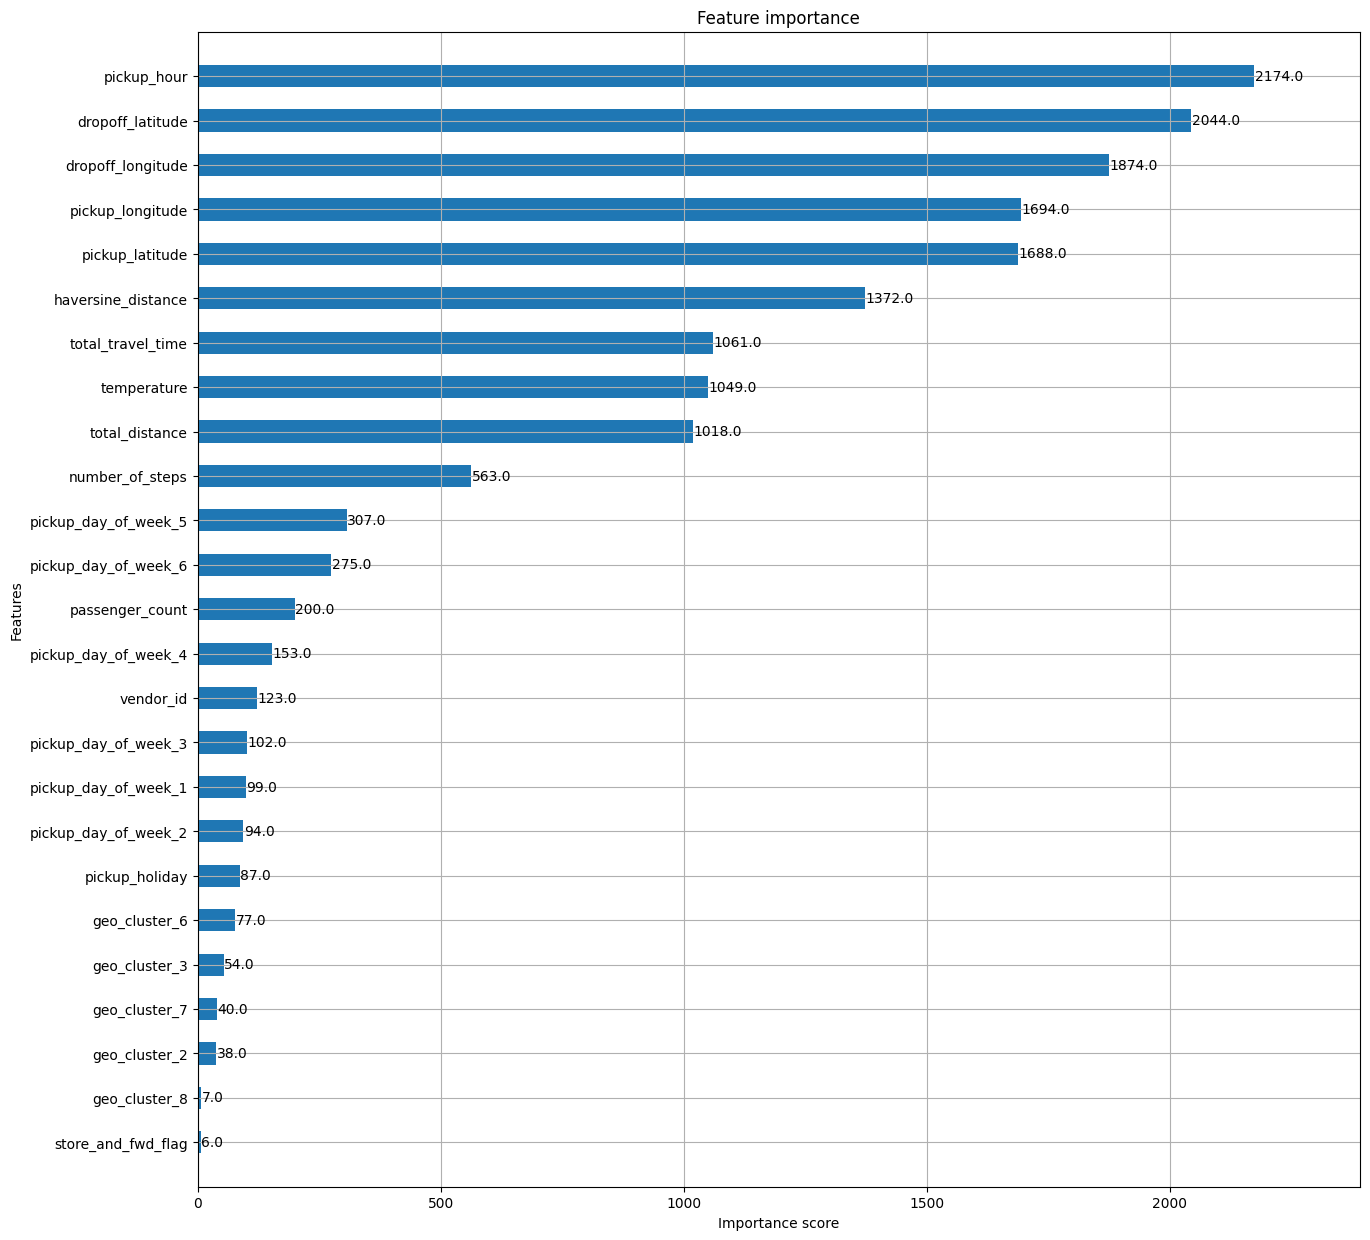

In [54]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)